# Import Libraries

In [5]:
import os
import pandas as pd
from edfoil.classes.airfoil import Airfoil
from edfoil.classes.section import Section
from edfoil.classes.station import Station

# Define method wrappers

This helps to create Station and Section instances for each row inside a pd.DataFrame.

In [15]:
def get_sta(row):
    return Station(
        airfoil = airfoils[row['airfoil']],
        chord = row['chord'],
        twist_angle = row['twist_angle'],
        x_offset = row['offset_x'],
        y_offset = row['offset_y'],
        z_offset = row['offset_z'],
        x_multiplier = row['multiplier_x'],
        y_multiplier = row['multiplier_y'],
        z_multiplier = row['multiplier_z'],
        x_mirror = row['mirror_x'],
        y_mirror = row['mirror_y'],
        # path = os.path.join(os.getcwd(),'airfoils',f'{row['airfoil']}.txt'),
    )

def get_sec(row):
    return Section(
        station = stations[row.name],
        n_plies = row['n_plies'],
        ply_thickness = row['ply_thickness'],
        overlap_target = row['overlap_target'],
        te_thickness = row['te_thickness'],
        bond_thickness = row['bond_thickness'],
        genFig = row['genFig'],
        saveFig = row['saveFig'],
        tolerance = row['tolerance'],
    )

# Import data
This includes station data, section parameters, and overlap parameters.

In [3]:
data_sta = pd.read_csv(f'resources\\examples\\exampleB\\data.txt')
data_sec = pd.read_csv(f'resources\\examples\\exampleB\\data_sec.txt')
data_jig = pd.read_csv(f'resources\\examples\\exampleB\\data_jig.txt')

# Create Airfoil instances

In [ ]:
airfoils = {}
for name in data_sta['airfoil'].unique():
    airfoil = Airfoil(name)
    airfoil.importCoords(f'edfoil/airfoils/{name}.txt')
    airfoils[name] = airfoil

# Create Station instances

In [16]:
stations = data_sta.apply(get_sta, axis=1).tolist()

# Create Section instances
Here we change some of the section values imported from the data.

In [17]:
# Changing the bond thickness in all stations to 3mm
data_sec['bond_thickness'] = 3

# Changing the ply thickness in all stations to 1mm
data_sec['ply_thickness'] = 1

# Changing the trailing edge thickness to 8mm
data_sec['te_thickness'] = 8

# Calculating the non-normalised values for the location of the overlap
# based on the local chord length.
data_sec['overlap_target'] = data_sec['overlap_target'] * data_sta['chord']

# Calculating the non-normalised values for the length of the overlap
# based on the local chord length.
data_jig['overlap_dist'] = data_jig['overlap_dist'] * data_sta['chord']

# Generating the sections
sections = data_sec.apply(get_sec,axis=1).tolist()

- Completed in 0.229s.

- Completed in 0.312s.

- Completed in 0.230s.

- Completed in 0.352s.

- Completed in 0.228s.



# Information query
We check the 3rd section instance and what it contains.

In [18]:
sections[2].info()

Station instance name: skin_1600
Parameters: ['n_plies', 'ply_thickness', 'overlap_target', 'te_thickness', 'bond_thickness', 'saveFig', 'base_airfoil', 'z', 'twist_angle', 'isCircle', 'u0_initial', 'colours']
Guides: ['chord', 'overlap_offset', 'overlap_start', 'TE']
Indexes: ['ply_cut_bot', 'ply_cut_top', 'LE', 'olp_sta', 'top_sta', 'te_bot', 'idx_te_top']
t-parameters: ['bot_ref', 'bot_splines', 'bot_plies', 'top_ref', 'top_splines', 'top_plies']
CubicSplines: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Points: ['bot_1', 'top_1']
Figures: ['section', 'bottom', 'bottom_trim', 'top', 'top_trim']


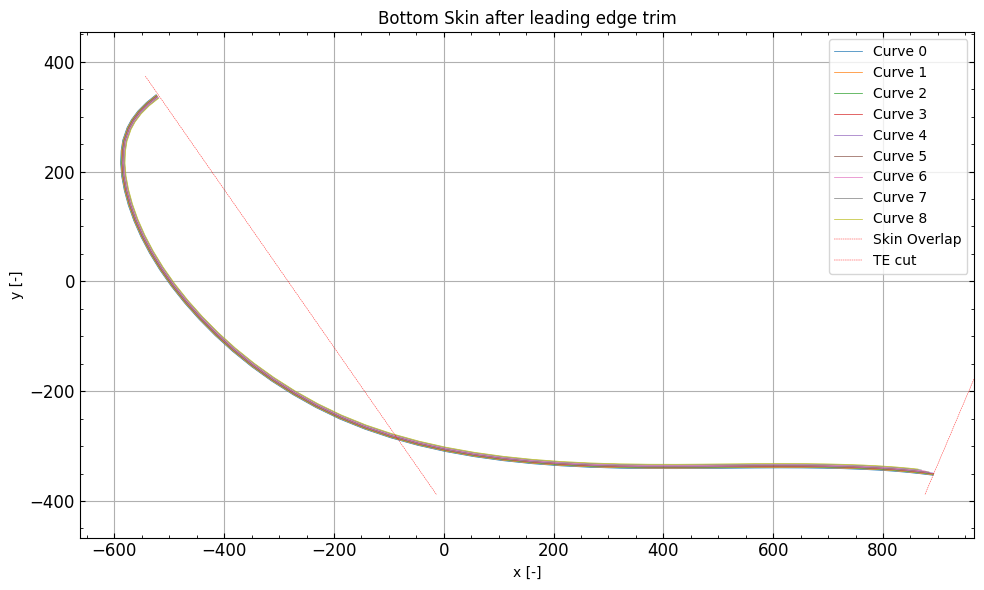

In [19]:
# Figure after the leading edge trimming

# We see the figures stored inside the instance

sections[2].figs['bottom_trim']

# Overlap length generation
We use the .jiggle method to create the bond and the underlying surface.

In [ ]:
for x in range(len(sections)):
    if data_jig['bond_thickness'][x] != 0:
        sections[x].jiggle(
            overlap_dist = data_jig['overlap_dist'][x], 
            bond_thickness = 3,
        )

# Trailing edge spar
We use the .teSpar method to generate a trailing edge spar with a given thickness and flange length.

In [21]:
for x in range(len(sections)):
    if data_jig['bond_thickness'][x] != 0:
        sections[x].teSpar(
            te_distance=220, 
            thickness=1, 
            flange_distance=50, 
            n_tePlies=2,
        )

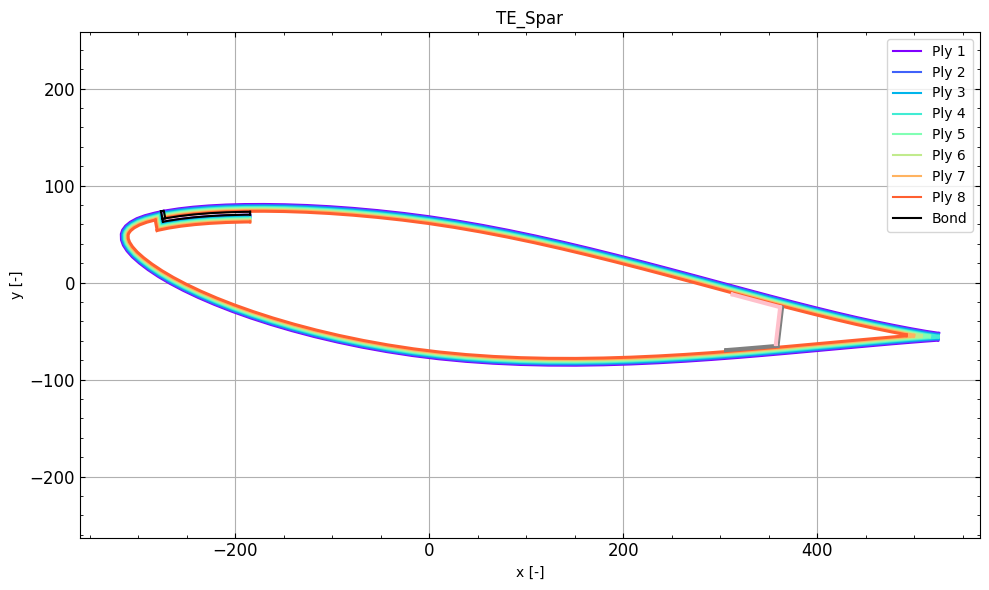

In [22]:
# Final figure including TE spar.
sections[-1].figs['TE_spar']

# Export
We export the skin, the bondline, and the trailing edge spar.
(Not implemented yet in the GUI)

In [23]:
# Define the export location
output_path = f'resources\\examples\\exampleB\\output'

# Create folders
## Skin
path_skin = f'{output_path}\\Skin'
os.makedirs(path_skin, exist_ok=True)

## Bond
path_bond = f'{output_path}\\Bond'
os.makedirs(path_bond, exist_ok=True)

## Overlap
path_olp  = f'{output_path}\\Overlap'
os.makedirs(path_olp, exist_ok=True)

## Trailing edge spar
path_tesp = f'{output_path}\\TESpar'
os.makedirs(path_tesp, exist_ok=True)

## Skin

In [24]:
# Skin

z_all = data_sta['offset_z'].tolist()

for side in ['top','bot']:
    for i in range(len(z_all)):
        for ply in range(1,sections[-1].parameters['n_plies']+1):
            for spline in [0,1]:
                x = sections[i].points[f'{side}_1'][ply][spline]['x']
                y = sections[i].points[f'{side}_1'][ply][spline]['y']
                z = [z_all[i]] * len(x)

                df = pd.DataFrame({'x':x,'y':y,'z':z})

                df.to_csv(
                    f'{path_skin}\\{side}_{z_all[i]}_{ply}_{spline}.csv', 
                    index = False, 
                    header = False,
                )

## Bondline

In [ ]:
# Bond

z_all = data_sta['offset_z'].tolist()

for sta in range(len(z_all)):
    
    if not sections[sta].parameters['isCircle']:
        
        # Horizontal part of the bondline
        for spline in [0,1]:
            x = sections[sta].points['bond'][0][spline]['x']
            y = sections[sta].points['bond'][0][spline]['y']
            z = [z_all[sta]] * len(x)

            df = pd.DataFrame({'x':x,'y':y,'z':z})

            df.to_csv(
                f'{path_bond}\\bH_{z_all[sta]}_{spline}.csv', 
                index = False, 
                header = False,
            )
            
        # Vertical part of the bondline
        x = sections[sta].points['bond'][1]['x']
        y = sections[sta].points['bond'][1]['y']
        z = [z_all[sta]] * len(x)

        df = pd.DataFrame({'x':x,'y':y,'z':z})

        df.to_csv(
            f'{path_bond}\\bV_{z_all[sta]}.txt', 
            index = False, 
            header = False,
        )

## Skin overlap

In [ ]:
# Jiggle and Overlap

z_all = data_sta['offset_z'].tolist()

for sta in range(len(z_all)):
    
    if not sections[sta].parameters['isCircle']:
    
        for ply in range(1,sections[-1].parameters['n_plies']+1):
            
            # Horizontal overlap
            for spline in [0,1]:
                    x = sections[sta].points[f'bot_3'][ply][spline]['x']
                    y = sections[sta].points[f'bot_3'][ply][spline]['y']
                    z = [z_all[sta]] * len(x)

                    df = pd.DataFrame({'x':x,'y':y,'z':z})

                    df.to_csv(
                        f'{path_olp}\\olp_{z_all[sta]}_{ply}_{spline}.csv', 
                        index = False, 
                        header = False,
                    )
            
            # Vertical overlap
            x = sections[sta].points['bot_2'][ply]['x']
            y = sections[sta].points['bot_2'][ply]['y']
            z = [z_all[sta]] * len(x)
            
            df = pd.DataFrame({'x':x,'y':y,'z':z})

            df.to_csv(
                f'{path_olp}\\jig_{z_all[sta]}_{ply}.csv', 
                index = False, 
                header = False,
            )

## Trailing edge spar

In [ ]:
# Rear Spar

z_all = data_sta['offset_z'].tolist()

for i in range(2,len(z_all)):
    for spline in [0,1]:
        x = sections[i].points['te_spar'][1][1][1][spline]['x']
        y = sections[i].points['te_spar'][1][1][1][spline]['y']
        z = [z_all[i]] * len(x)

        df = pd.DataFrame({'x':x,'y':y,'z':z})

        df.to_csv(
            f'{path_tesp}\\tesp_{z_all[i]}_{spline}.csv', 
            index = False, 
            header = False,
        )